In [3]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt

import IMNN
print("IMNN version: ", IMNN.__version__)

from IMNN.experimental.jax.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from IMNN.experimental.jax.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from IMNN.experimental.jax.utils import value_and_jacrev #, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.8
IMNN version:  0.2dev


In [43]:
np.less_equal(1, 0)

DeviceArray(False, dtype=bool)

In [203]:
# Define a log_normal field class


class LogNormalField:
    @staticmethod
    def compute_rsquared(nside):
        """
        Compute the correlation function of the underlying gaussian field
        
        Parameters:
            nside : int
                Image is nside x nside pixels
        """
        import jax.numpy as np
        from scipy.linalg import toeplitz
        
        _Di = np.tile(toeplitz(np.arange(nside)),(nside,nside))
        _Dj = np.concatenate(
                            [np.concatenate(
                                            [np.tile(np.abs(i-j),(nside,nside)) for i in range(nside)],
                                            axis=0)
                            for j in range(nside)],axis=1)
        _distance_squared = _Di*_Di+_Dj*_Dj
        
        return _distance_squared

    # The lognormal correlation function where the gaussian field has a gaussian power spectrum,
    # and the gaussian correlation function xi_G.

    @staticmethod
    def xi_G(rsq, beta):
        """
        Calculates the two-point correlation function of a gaussian field with gaussian power spectrum
        
        Parameters:
        
        rsq : float
            separation^2
        beta  : float
            Gaussian smoothing width of gaussian field
        """
        import jax.numpy as np
        
        # ADD IN SIGMA PARAM HERE
        
        xi = np.exp(-0.25*rsq/(beta**2))
            
        return xi
    
    @staticmethod
    def fill_zeros(k, value):
        from functools import partial
        
        def fnk(k):
            return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: 0., lambda k: k+value, operand=k)

        if len(k.shape) == 1:
            return jax.vmap(fnk)(k)
        else:
            return jax.vmap(partial(fill_zeros, value=value))(k)

    @staticmethod
    def xi_LN(r, beta, alpha, PixelNoise):
        """
        Calculates the lognormal two-point correlation function
        
        Parameters:
        
        r : float
            Pair separation
        beta  : float
            Gaussian smoothing width of underlying gaussian field
        alpha : float
            Nongaussianity parameter in lognormal transformation
        PixelNoise : float
            Standard deviation of added noise per pixel
        """
        import jax.numpy as np
        
        xi = 1/(np.power(alpha+1e-12,2)) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
        
        # Add pixel noise at zero separation:
                
        xi = self.fill_zeros(xi, PixelNoise**2)
        #xi[np.where(r<1e-5)] += PixelNoise**2
        
        return xi
    
    @staticmethod
    def dxi_LN_dalpha(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return 2/(alpha+1e-12) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 2/np.power(alpha+1e-12,3) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
    
    @staticmethod
    def dxi_LN_dbeta(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return (-0.5*r/np.power(beta,2)) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2)))

    def __init__(self,Lside,rmax,nbin):
        """
        
        Parameters:
            rmax : float
                Maximum pair separation considered
            nbin : int
                Number of bins for shell-averaged correlation function
        """
        import jax.numpy as np
        
        self.rmax       = rmax
        self.nbin       = nbin
        self.Lside      = Lside

        # compute the separations and indices on a grid
        self.rsq        = self.compute_rsquared(Lside)
        self.r          = np.sqrt(self.rsq)
        self.bins       = np.arange(nbin)*rmax/nbin
        self.index      = np.digitize(self.r,self.bins)
        self.average_r  = np.array([self.r[self.index == n].mean() for n in range(nbin) if np.sum(self.index == n)>0])
    
    @staticmethod
    def G_to_LN(gaussian, alpha):
        import jax.numpy as np
        
        # Make lognormal (variance of gaussian field is unity by construction)
        # Divide by 1/alpha so that the signal-to-noise ratio is independent of alpha
        return 1./alpha * (np.exp(alpha * gaussian-0.5*alpha**2)-1)
    
    def run_simulation(self, key, alpha, beta, PixelNoise):
        """
        Create a lognormal field from a gaussian field with a Gaussian correlation function
        """
        import jax.numpy as np
        
        # split keys, one for field and one for noise
        key1,key2 = jax.random.split(key)
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        # Compute the Gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        print('xiG shape: ', xiG.shape)
        
        # Compute the Gaussian random field
        #field = (jax.random.multivariate_normal(key1, np.zeros(Lside*Lside), xiG)).reshape(Lside,Lside)
        
        print('field shape: ', field.shape)
        
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(field, alpha)
        
        # Add noise
        field += jax.random.normal(key2, shape=(Lside,Lside))*np.sqrt(PixelNoise)
        
        return field
    
    def pymc3_model(self, field_data, alphamin, alphamax, betamin, betamax, PixelNoise):
        import numpy as np
        import pymc3 as pm
        LN_model = pm.Model()
        
        Lside              = self.Lside
        rsq                = self.rsq
        zero               = np.zeros(Lside*Lside)
        PixelNoiseVector   = PixelNoise*np.ones(Lside*Lside)
        InvNoiseCovariance = np.diag(1/(PixelNoiseVector**2))
        field_data         = field_data.reshape(Lside*Lside)

        with LN_model:
            
            # (TLM) TODO: add in μ,σ for full BHM

            # Uniform priors for unknown model parameters (alpha,beta):

            alpha_p   = pm.Uniform("alpha", lower=alphamin, upper=alphamax)
            beta_p    = pm.Uniform("beta",  lower=betamin,  upper=betamax)

            # Compute (beta-dependent) gaussian field correlation function:

            xi = pm.math.exp(-0.25*rsq/(beta_p*beta_p))

            # Gaussian field values are latent variables:
            gaussian = pm.MvNormal("gaussian",mu=zero,cov=xi,shape=Lside*Lside)

            # Expected value of lognormal field, for given (alpha, beta, gaussian):

            muLN = 1/alpha_p * (pm.math.exp(alpha_p * gaussian-0.5*alpha_p*alpha_p)-1)

            # Likelihood (sampling distribution) of observations, given the mean lognormal field:

            Y_obs = pm.MvNormal("Y_obs", mu=muLN, tau=InvNoiseCovariance, observed=field_data)
        
        return LN_model
    
    def run_diff_simulation(self, alpha, beta, PixelNoise, step, seed):
        """
        Run simulations for finite differencing
        """
        import numpy as np
        from scipy.stats import multivariate_normal
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        alphap     = alpha*(1+step)
        alpham     = alpha*(1-step)
        betap      = beta*(1+step)
        betam      = beta*(1-step)
        
        # Compute the gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        xiG_betap = self.xi_G(rsq,betap)
        xiG_betam = self.xi_G(rsq,betam)
        
        # Compute Gaussian random fields with the same phases
        Gfield = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betap = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betap).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betam = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betam).rvs(random_state=seed).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(Gfield, alpha)
        field_betap = self.G_to_LN(Gfield_betap, alpha)
        field_betam = self.G_to_LN(Gfield_betam, alpha)
        field_alphap = self.G_to_LN(Gfield, alphap)
        field_alpham = self.G_to_LN(Gfield, alpham)
        
        # Add noise
        noise = np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        field += noise
        field_betap += noise
        field_betam += noise
        field_alphap += noise
        field_alpham += noise
        
        return field, field_alphap, field_alpham, field_betap, field_betam
    
    def compute_corrfn(self,field):
        """
        Compute two-point correlation function
        """       
        import numpy as np
        
        index    = self.index
        nbin     = self.nbin
        
        # compute the correlations
        correlations = np.outer(field,field)
        corrfn = np.array([correlations[index==n].mean() for n in range(nbin) if len(correlations[index==n])>0])
        
        return corrfn
    
    def compute_corrfn_derivatives(self, field, field_alphap, field_alpham, field_betap, field_betam, step):
        """
        Compute derivatives of the two-point correlation function
        """
        
        # Compute correlation functions
        corrfn         = self.compute_corrfn(field)
        corrfn_dalphap = self.compute_corrfn(field_alphap)
        corrfn_dalpham = self.compute_corrfn(field_alpham)
        corrfn_dbetap  = self.compute_corrfn(field_betap)
        corrfn_dbetam  = self.compute_corrfn(field_betam)
        
        # Compute derivatives by second-order central finite differences
        dcorrfn_dalpha = (corrfn_dalpham - 2*corrfn + corrfn_dalphap)/(step**2)
        dcorrfn_dbeta  = (corrfn_dbetam  - 2*corrfn + corrfn_dbetap )/(step**2)
        
        return dcorrfn_dalpha, dcorrfn_dbeta
    
    def covariance(self,fields):
        """
        Compute covariance from a number of fields
        
        Parameter:
            fields : int
                lognormal field objects contributing to the covariance matrix
        """
        import numpy as np
        
        nsims  = len(fields)
        nbins  = self.nonzerobins
        
        print('Number of simulations',nsims)
        print('Number of non-zero pair bins',nbins)
        
        corrfns = np.array([fields[i]['corrfn'] for i in range(nsims)])
        meanxi = np.mean(corrfns,axis=0)
        covxi = np.cov(corrfns.T)
        
        return meanxi, covxi
    
    # Utility properties
    @staticmethod
    def var_th(alpha, PixelNoise):
        import numpy as np
        return 1/np.power(alpha+1e-12,2)*(np.exp(alpha**2)-1)+PixelNoise**2
    @staticmethod
    def skew_th(alpha):
        import numpy as np
        return (np.exp(alpha**2)+2)*np.sqrt(np.exp(alpha**2)-1)
    @staticmethod
    def dskew_dalpha(alpha):
        import numpy as np
        return 2*alpha*np.exp(alpha**2) * ( np.sqrt(np.exp(alpha**2)-1) - 0.5*(np.exp(alpha**2)+2)/(np.sqrt(np.exp(alpha**2)-1)) )
    @staticmethod
    def kurtosis_th(alpha):
        import numpy as np
        return np.exp(4*alpha**2)+2*np.exp(3*alpha**2)+3*np.exp(2*alpha**2)-6
    @staticmethod
    def dkurtosis_dalpha(alpha):
        import numpy as np
        return 8*alpha*np.exp(4*alpha**2)+6*alpha*np.exp(3*alpha**2)+6*alpha*np.exp(2*alpha**2)
    @staticmethod
    def max(field):
        import numpy as np
        return np.max(field)
    @staticmethod
    def min(field):
        import numpy as np
        return np.min(field)
    @staticmethod
    def var(field):
        import numpy as np
        return np.var(field)
    @staticmethod
    def mean(field):
        import numpy as np
        return np.mean(field)
    @staticmethod
    def skew(field):
        from scipy.stats import skew
        return skew(field.flatten())
    @staticmethod
    def kurtosis(field):
        from scipy.stats import kurtosis
        return kurtosis(field.flatten())
    
    # xi has empty bins removed.  Note the number of non-empty elements
    @property
    def nonzerobins(self):
        return len(self.average_r)
    
    @property
    def dt(self):
        import numpy as np
        return np.dtype([('field', np.float, (self.Lside,self.Lside)), ('corrfn', np.float, (self.nonzerobins))])
# end class LogNormalField


In [268]:
Lside       = 16
alpha       = 1.0
beta        = 0.5
PixelNoise  = 0.01

# Setup for correlation function
nbin        = 4*Lside
ndata       = 4*Lside
rmax        = Lside*np.sqrt(2)


In [269]:
LN=LogNormalField(Lside,rmax,nbin)
field = LN.run_simulation(key, 1.0, 0.5, 0.01)

In [270]:
rng,key = jax.random.split(rng)

In [271]:
field = LN.run_simulation(key, 1.0, 0.5, 0.01)

xiG shape:  (256, 256)
field shape:  (16, 16)


In [259]:
LN.rsq.shape

(1024, 1024)

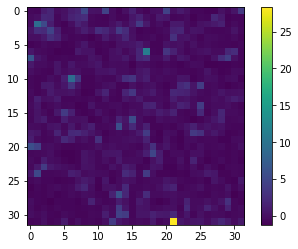

In [260]:
plt.imshow(field)
plt.colorbar()

In [261]:
LN.average_r.shape

(113,)

In [331]:
simulator_args = {'N': 32, 'squeeze': False}
def simulator(rng, θ, simulator_args=simulator_args):
    A,B = θ
    noise = 0.01
    def fn(key, A,B):
        if simulator_args['squeeze']:
            return np.expand_dims(LN.run_simulation(key,A,B,noise), 0)

        else:
            return (np.expand_dims(np.expand_dims(LN.run_simulation(key,A,B,noise), 0), 0))

    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)
    

In [332]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [264]:
simulation.shape

(1, 1, 128, 128)

xiG shape:  (16384, 16384)
field shape:  (128, 128)


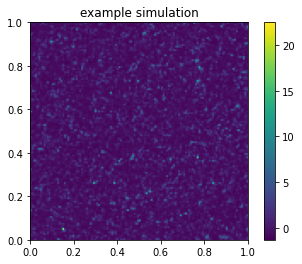

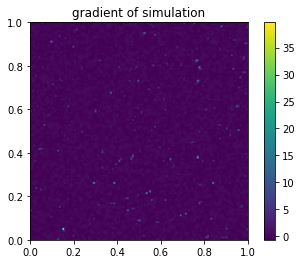

In [221]:
rng,key = jax.random.split(rng)
θ_fid = np.array([1.0, 0.5], dtype=np.float32)
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=simulator_args)

plt.imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
plt.colorbar()
plt.title('example simulation')
plt.show()

plt.imshow(np.squeeze(simulation_gradient[0].T[0].T), extent=(0,1,0,1))
plt.title('gradient of simulation')
plt.colorbar()
plt.show()

# set up model

In [184]:
n_params = 2
n_summaries = 2
θ_fid = np.array([1.0, 0.5], dtype=np.float32)
N = Lside
input_shape = (1,1, N,N)

# IMNN params
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [185]:
LN.rsq.shape

(256, 256)

In [186]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

In [187]:
def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME"))

    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)

In [188]:
fs = 32
model = stax.serial(
        #InceptBlock2((fs,fs,fs), strides=(4,4)),
        #InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten
)

In [189]:
optimiser = optimizers.adam(step_size=1e-3)

In [190]:
from IMNN.experimental.jax.imnn._imnn import _IMNN
from IMNN.experimental.jax.utils import check_simulator, value_and_jacrev


class SimIMNN(_IMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, verbose=True):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            verbose=verbose)
        self.simulator = check_simulator(simulator)
        self.simulate = True

    def get_fitting_keys(self, rng):
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key, validate=False):
        def get_summary(key, θ):
            return self.model(w, self.simulator(key, θ))

        def get_derivatives(key):
            return value_and_jacrev(get_summary, argnums=1)(key, self.θ_fid)

        keys = np.array(jax.random.split(key, num=self.n_s))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:self.n_d])
        if self.n_s > self.n_d:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=self.θ_fid))(keys[self.n_d:])])
        return np.squeeze(summaries), np.squeeze(derivatives)
    
    
import jax
import jax.numpy as np
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.utils import value_and_jacrev, check_devices, \
    check_type, check_splitting


class AggregatedSimulatorIMNN(SimulatorIMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator, devices,
                 n_per_device, verbose=True):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            simulator=simulator,
            verbose=verbose)
        self.devices = check_devices(devices)
        self.n_devices = len(self.devices)
        self.n_per_device = check_type(n_per_device, int, "n_per_device")
        if self.n_s == self.n_d:
            check_splitting(self.n_s, "n_s and n_d", self.n_devices,
                            self.n_per_device)
        else:
            check_splitting(self.n_s, "n_s", self.n_devices, self.n_per_device)
            check_splitting(self.n_d, "n_d", self.n_devices, self.n_per_device)

    def get_summaries(self, w, key=None, validate=False):
        def derivative_scan(counter, rng):
            def get_device_summaries(rng):
                def get_summary(key, θ):
                    return self.model(w, self.simulator(key, θ))

                def get_derivatives(rng):
                    return value_and_jacrev(get_summary, argnums=1)(
                        rng, self.θ_fid)

                keys = np.array(jax.random.split(rng, num=self.n_per_device))
                return jax.vmap(get_derivatives)(keys)

            keys = np.array(jax.random.split(rng, num=self.n_devices))
            summaries, derivatives = jax.pmap(
                get_device_summaries, devices=self.devices)(keys)
            return counter, (summaries, derivatives)

        def summary_scan(counter, rng):
            def get_device_summaries(rng):
                def get_summary(key):
                    return self.model(w, self.simulator(key, self.θ_fid))

                keys = np.array(jax.random.split(rng, num=self.n_per_device))
                return jax.vmap(get_summary)(keys)

            keys = np.array(jax.random.split(rng, num=self.n_devices))
            summaries = jax.pmap(
                get_device_summaries, devices=self.devices)(keys)
            return counter, summaries

        n = self.n_d // (self.n_devices * self.n_per_device)
        if self.n_s > self.n_d:
            n_r = (self.n_s - self.n_d) // (self.n_devices * self.n_per_device)
            key, *keys = jax.random.split(key, num=n_r + 1)
            counter, remaining_summaries = jax.lax.scan(
                summary_scan, n_r, np.array(keys))
        keys = np.array(jax.random.split(key, num=n))
        counter, results = jax.lax.scan(
            derivative_scan, 0, keys)
        summaries, derivatives = results
        if self.n_s > self.n_d:
            summaries = np.vstack([summaries, remaining_summaries])
        return (summaries.reshape((-1, self.n_summaries)),
                derivatives.reshape((-1, self.n_summaries, self.n_params)))



In [191]:
IMNN = SimIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
#         devices=[jax.devices()[0]],
#         n_per_device=1000
        )

In [192]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator, InceptNet\n"
]

In [351]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);

xiG shape:  (256, 256)
field shape:  (16, 16)
CPU times: user 4min 15s, sys: 44.5 ms, total: 4min 15s
Wall time: 4min 15s


In [352]:
IMNNs = [IMNN]

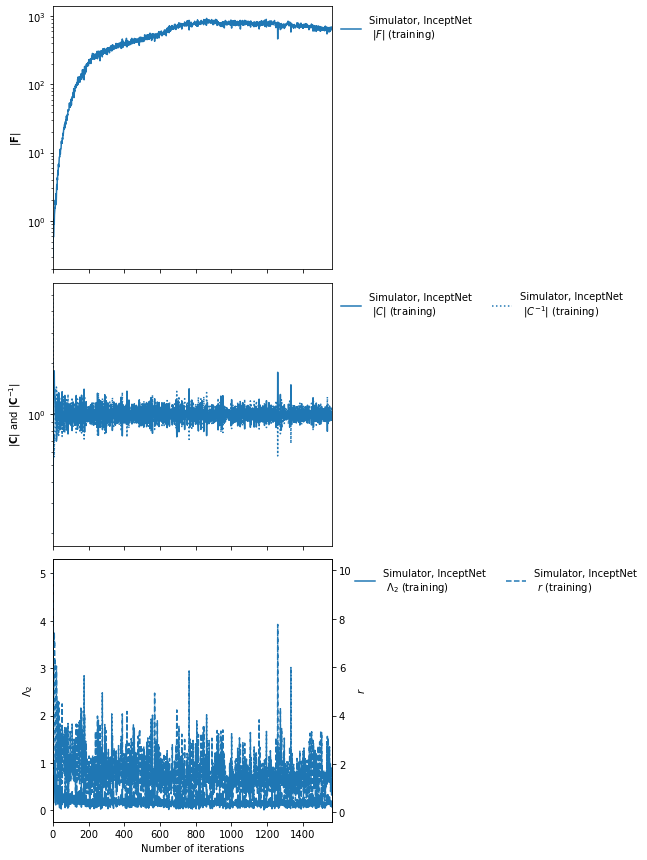

In [353]:
for i, (IMNN, label) in enumerate(zip(IMNNs, labels)):
    if i == 0:
        ax = IMNN.training_plot(expected_detF=None, colour="C{}".format(i), label=label)
    elif i == 10:
        other_ax = IMNN.training_plot(
            expected_detF=None, colour="C{}".format(i), label=label
        )
    elif i == 11:
        IMNN.training_plot(
            ax=other_ax,
            expected_detF=50, colour="C{}".format(i), label=label
        )
        other_ax[0].set_yscale("log")
        other_ax[2].set_yscale("log")
    else:
        IMNN.training_plot(
            ax=ax, expected_detF=None, colour="C{}".format(i), label=label, ncol=5
        );
ax[0].set_yscale("log")

In [354]:
IMNN.F

DeviceArray([[  6.7903223, -10.160338 ],
             [-10.160339 , 139.6059   ]], dtype=float32)

# ABC inference

In [277]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)


prior = uniform([0.1, 0.1], [1.6, 1.6])
#prior = uniform([0.1, 0.1], [5.0, 3.0])

In [341]:
rng, key = jax.random.split(rng)
θ_target = np.array([0.9, 0.6])
target_data = simulator(
    key,
    θ_target,
    simulator_args={**simulator_args, **{'squeeze':False}})

xiG shape:  (256, 256)
field shape:  (16, 16)


In [355]:
@jit #partial(jax.jit, static_argnums=0)
def get_estimate(d):
    if len(d.shape) == 1:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)
    else:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)

In [356]:
estimates = get_estimate(target_data) #[i.get_estimate(target_data) for i in IMNNs];

In [357]:
GAs = [GaussianApproximation(get_estimate(target_data), IMNN.invF, prior)]

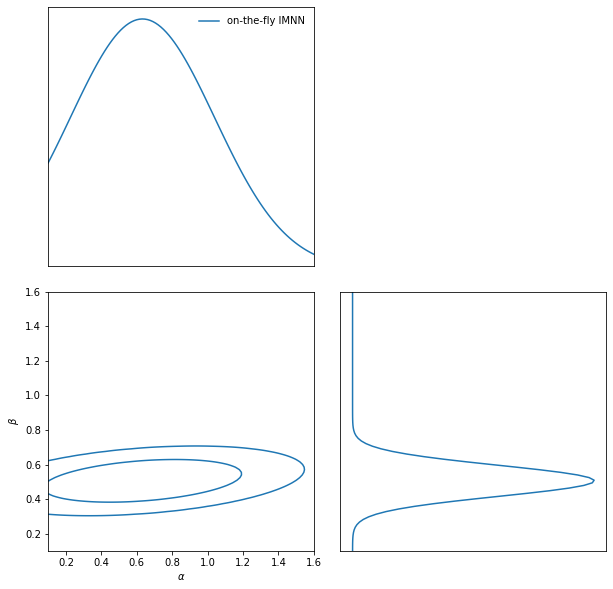

In [358]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$\alpha$", r"$\beta$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

In [346]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':True}}), 
                                       get_estimate, F=IMNN.F, gridsize=50
    )

In [347]:
target_data.shape

(1, 1, 16, 16)

In [348]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=20000,
        ϵ=0.05,
        smoothing=0.);

xiG shape:  (256, 256)
field shape:  (16, 16)
3350 accepted in last  20000 iterations  (20000000 simulations done).
CPU times: user 2min 10s, sys: 668 ms, total: 2min 11s
Wall time: 2min 13s


(<IMNN.experimental.jax.utils.container.container at 0x154c58d90dd8>,
 <IMNN.experimental.jax.utils.container.container at 0x154c58d90f28>)

In [349]:
ABC.parameters.accepted[0].shape

(3350, 2)

In [ ]:
α

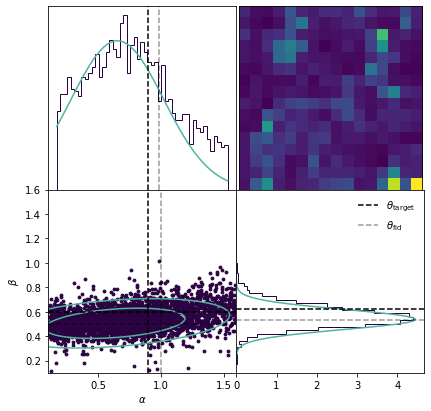

In [372]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
#latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$\alpha$", r"$\beta$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$\alpha$", r"$\beta$"], label=None, ncol=1)
ax[0,1].imshow(target_data[0, 0])
ax[0,1].set_yticks([])

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$\alpha$')
ax[1,0].set_ylabel(r'$\beta$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[0,0].set_yticks([])
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')
ax[1,1].set_yticks([])
#ax[1,1].plot(np.real(loglikeB), B_range, color='g', label='loglikeB')
ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
# ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
# ax[0, 1].axis("off")
# ax[1, 0].contour(A_range, B_range, np.real(likelihood), levels=value, colors='#FF8D33')
# ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)


#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-contours.png', dpi=400)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [222]:
import powerbox as pbox

In [246]:
α = 1.0
β = 0.5
#mf = hmf.MassFunction(z=0)

# Generate a callable function that returns the cosmological power spectrum.
power = lambda k : ((1 / α**2) * np.exp(α**2 * np.exp(-0.25 * (k**2 / β**2)) - 1))

# Create the power-box instance. The boxlength is in inverse units of the k of which pk is a function, i.e.
# Mpc/h in this case.
pb = pbox.LogNormalPowerBox(N=128, dim=2, pk = power, boxlength= 128., seed=123)

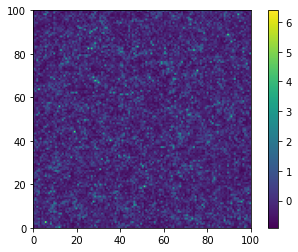

In [250]:
plt.imshow(pb.delta_x(), extent=(0,100,0,100))
plt.colorbar()
plt.show()